Tenzing Palden CIS 4130 Pyspark File

<h1>
-----Data Loading Starts here-----
</h1>

In [1]:
import six
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, round, stddev, avg, mean, expr, col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl

In [2]:
spark = SparkSession.builder \
    .appName("single_csv") \
    .getOrCreate()

In [3]:
#get version of pyspark for future refernece
print('Apache Spark Version :'+spark.version)
print('Apache Spark Version :'+spark.sparkContext.version)

Apache Spark Version :3.3.1
Apache Spark Version :3.3.1


In [4]:
#reading data from csv into pyspark df
path = r"trip_data\yellow_tripdata_2019-01.csv"
df = spark.read.csv(path, inferSchema= True, header=True)

<h1>
-----Data Preprocessing starts here-----
</h1>

In [5]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [6]:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

Number of rows: 7667792
Number of columns: 18


In [7]:
# creating a list of column names
cols = df.columns

# iterate through the list of column names
for col in cols:
    # get the number of missing values for each column
    missing_count = df.filter(df[col].isNull()).count()
    # print the column name and number of missing values
    print(f"Column {col}: {missing_count} missing values")

Column VendorID: 0 missing values
Column tpep_pickup_datetime: 0 missing values
Column tpep_dropoff_datetime: 0 missing values
Column passenger_count: 0 missing values
Column trip_distance: 0 missing values
Column RatecodeID: 0 missing values
Column store_and_fwd_flag: 0 missing values
Column PULocationID: 0 missing values
Column DOLocationID: 0 missing values
Column payment_type: 0 missing values
Column fare_amount: 0 missing values
Column extra: 0 missing values
Column mta_tax: 0 missing values
Column tip_amount: 0 missing values
Column tolls_amount: 0 missing values
Column improvement_surcharge: 0 missing values
Column total_amount: 0 missing values
Column congestion_surcharge: 4855978 missing values


In [5]:
# Calculate the difference between the "start_time" and "end_time" columns in seconds and then making them secondds
df = df.withColumn("total_time", unix_timestamp(df["tpep_dropoff_datetime"]) - unix_timestamp(df["tpep_pickup_datetime"]))
df = df.withColumn("total_time", round(df["total_time"]/60, 2))

In [6]:
#finding the columns with the datatype double and converting them into int
double_cols=["passenger_count", "trip_distance", "RatecodeID", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount","improvement_surcharge", "total_amount","congestion_surcharge", "total_time"]
new_df = df
for col in double_cols:
    new_df = new_df.withColumn(col,new_df[col].cast('integer'))

new_df=new_df.drop("tpep_pickup_datetime", "tpep_dropoff_datetime", "VendorID", "payment_type")

#check new datatypes
new_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: integer (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- fare_amount: integer (nullable = true)
 |-- extra: integer (nullable = true)
 |-- mta_tax: integer (nullable = true)
 |-- tip_amount: integer (nullable = true)
 |-- tolls_amount: integer (nullable = true)
 |-- improvement_surcharge: integer (nullable = true)
 |-- total_amount: integer (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- total_time: integer (nullable = true)



In [7]:
int_cols = ["passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount","improvement_surcharge", "total_amount","congestion_surcharge", "total_time"]
new_df.describe(int_cols).show()

+-------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+---------------------+------------------+--------------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|              extra|             mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        total_time|
+-------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+---------------------+------------------+--------------------+------------------+
|  count|           7667792|           7667792|           7667792|            7667792|             7667792|           7667792|            7667792|              7667792|           7667792|             2811814|           7667792|
|   mean|1.5670782410373156|2.3143901138685035|12.164738688790724|0.18810186817795788|1.

<h1>
-----removing outliers from Data-----
</h1>

In [8]:
#making a df with only integrs 
int_only_df = df.select(int_cols)

cols = int_only_df.columns

In [12]:
#corrrelation before outlier removal. Good to see how much the data was effected
#this code is copied from online. Finding correlations from features and total_amount
for i in int_only_df.columns:
    if not( isinstance(int_only_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to total_amount for ", i, int_only_df.stat.corr('total_amount',i))

Correlation to total_amount for  passenger_count -0.0002649618372716289
Correlation to total_amount for  trip_distance 0.046784009213639954
Correlation to total_amount for  fare_amount 0.9998972182351565
Correlation to total_amount for  extra 0.1926024495695529
Correlation to total_amount for  mta_tax 0.0016739039535502407
Correlation to total_amount for  tip_amount 0.0361397649281151
Correlation to total_amount for  tolls_amount 0.029530760416489773
Correlation to total_amount for  improvement_surcharge -0.0030907327804910083
Correlation to total_amount for  total_amount 1.0
Correlation to total_amount for  congestion_surcharge -1.3889261344064291e-05
Correlation to total_amount for  total_time 0.0057623477658700325


In [13]:
#removing outliers from data. takes 34 seconds.
from pyspark.sql.functions import stddev, avg, mean

for col in cols:
    col_mean = int_only_df.select(mean(int_only_df[col])).first()[0]
    col_std = int_only_df.select(stddev(int_only_df[col])).first()[0]

    # Filter out the outliers using the mean and standard deviation
    int_only_df = int_only_df.filter((int_only_df[col] > col_mean - 3 * col_std) & (int_only_df[col] < col_mean + 3 * col_std))


In [14]:
#this code is copied from online. Checkinig correlation again. HUGE DIFFERENCE
for i in int_only_df.columns:
    if not( isinstance(int_only_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to total_amount for ", i, int_only_df.stat.corr('total_amount',i))

Correlation to total_amount for  passenger_count 0.006739776421012047
Correlation to total_amount for  trip_distance 0.894502710073033
Correlation to total_amount for  fare_amount 0.9746354293853896
Correlation to total_amount for  extra 0.08148393950689095
Correlation to total_amount for  mta_tax nan
Correlation to total_amount for  tip_amount 0.6083976378784373
Correlation to total_amount for  tolls_amount 0.025395370169026883
Correlation to total_amount for  improvement_surcharge 0.0068221347453798235
Correlation to total_amount for  total_amount 1.0
Correlation to total_amount for  congestion_surcharge nan
Correlation to total_amount for  total_time 0.8964863840655704


<h1>
-----Linear Regression starts here-----
</h1>

In [15]:
featureassembler = VectorAssembler(inputCols=["trip_distance","tip_amount", "total_time"], outputCol= "Independant Features")
output= featureassembler.transform(int_only_df)
output.select("Independant Features").show()
finalised_data = output.select("Independant Features", "total_amount")

+--------------------+
|Independant Features|
+--------------------+
|      [0.6,1.5,2.02]|
|      [2.2,1.0,9.83]|
|    [2.5,2.35,11.58]|
|      [0.4,0.0,2.25]|
|     [1.9,2.05,10.1]|
|       [0.3,1.4,4.8]|
|      [1.0,1.0,4.27]|
|      [0.8,0.0,6.73]|
|      [1.2,1.65,7.9]|
|     [1.8,1.95,11.7]|
|     [1.1,1.45,6.57]|
|     [1.9,0.0,10.52]|
|      [0.5,0.0,2.93]|
|     [0.5,1.05,3.65]|
|     [0.8,1.15,4.68]|
|    [1.0,1.85,11.13]|
|     [2.3,1.5,17.15]|
|    [2.3,2.95,21.15]|
|      [0.3,0.85,2.2]|
|     [1.5,1.85,9.45]|
+--------------------+
only showing top 20 rows



In [16]:
train_set, test_set = finalised_data.randomSplit([0.8, 0.2])

In [17]:
reg = LinearRegression(featuresCol="Independant Features", labelCol= "total_amount")
lr_model  = reg.fit(train_set)

In [18]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.7949373648365317,1.0569898625749612,0.3586709532036035]
Intercept: 3.2848260048069915


----prediction----

In [19]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.786394
r2: 0.980574


In [20]:
lr_predictions = lr_model.transform(test_set)
lr_predictions.show()

+--------------------+------------+------------------+
|Independant Features|total_amount|        prediction|
+--------------------+------------+------------------+
|      [0.5,0.0,2.93]|         4.8|5.2332005801118155|
|      [1.2,1.65,7.9]|        9.95|10.016284646167982|
|     [1.8,1.95,11.7]|       11.75|12.773293646016082|
|     [2.3,1.5,17.15]|        14.8|15.149873585235254|
|     [0.8,1.45,4.87]|        8.75|  8.00013873951146|
|     [1.4,1.95,10.7]|       11.75|11.696647746877867|
|    [1.5,2.35,15.33]|       14.15|13.959583941724189|
|     [1.8,1.0,15.45]|        13.8|13.114169351083383|
|      [2.3,3.8,19.0]|        19.1|18.244491532584334|
|           (3,[],[])|         3.8|3.2848260048069915|
|       [0.0,0.0,0.2]|         3.8|3.3565601954477122|
|       [0.0,0.0,0.2]|         3.8|3.3565601954477122|
|      [0.0,0.0,0.37]|         3.8|3.4175342574923246|
|      [0.1,0.0,1.82]|         4.3| 4.117100876121203|
|     [0.1,0.64,1.47]|        4.94| 4.668039554547917|
|     [0.1

In [21]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_amount",metricName="r2")
                 
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.981351


<h1>
-----Logistic Regression starts here-----
</h1>

In [22]:
#this makes a new column that shows weather the p[erson tipped or not. When tipped the value is 1. When not tipped the value is 0
int_only_df = int_only_df.withColumn("tip_binary", expr("CASE WHEN tip_amount > '0' THEN '1' " + 
               "WHEN tip_amount <= '0' THEN '0' WHEN tip_amount IS NULL THEN ''" +
               "ELSE tip_amount END"))

int_only_df = int_only_df.withColumn("tip_binary",int_only_df["tip_binary"].cast('integer'))


In [23]:
featureassembler = VectorAssembler(inputCols=["passenger_count", "trip_distance", "fare_amount", "tolls_amount", "congestion_surcharge"], outputCol= "features")

In [24]:
output= featureassembler.transform(int_only_df)
log_moel_df= output.select("features", "tip_binary")
train_set, test_set = log_moel_df.randomSplit([0.7, 0.3])

In [25]:
log_reg = LogisticRegression(labelCol="tip_binary").fit(train_set)

In [26]:
log_results = log_reg.evaluate(train_set).predictions

c:\Users\tpald\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [27]:
results = log_reg.evaluate(test_set).predictions

In [28]:
tp = results[(results.tip_binary == 1) & (results.prediction == 1)].count()
tp

524437

In [29]:
tn = results[(results.tip_binary == 0) & (results.prediction == 0)].count()
tn

87

In [30]:
fp = results[(results.tip_binary == 0) & (results.prediction == 1)].count()
fp 

222982

In [31]:
fn = results[(results.tip_binary == 1) & (results.prediction == 0)].count()
fn 

38

In [32]:
    print(f"The TP is {tp}")
    print(f"The TN is {tn}")
    print(f"The FP is {fp}")
    print(f"The FN is {fn}")


The TP is 524437
The TN is 87
The FP is 222982
The FN is 38


In [33]:
print(f"The accuracy of this model is {float((tp+tn)/results.count())}")

The accuracy of this model is 0.7016630459210428


In [40]:
print(f"The recall of this model is {float(tn)/(tp+tn)}")

The recall of this model is 0.00016586466968146357


<h1>
-----VISUALIZATIONS starts here-----
</h1>

In [35]:
mpl.style.use('classic')
lr_predict_pd = lr_predictions.toPandas()

Text(0, 0.5, 'Predicted')

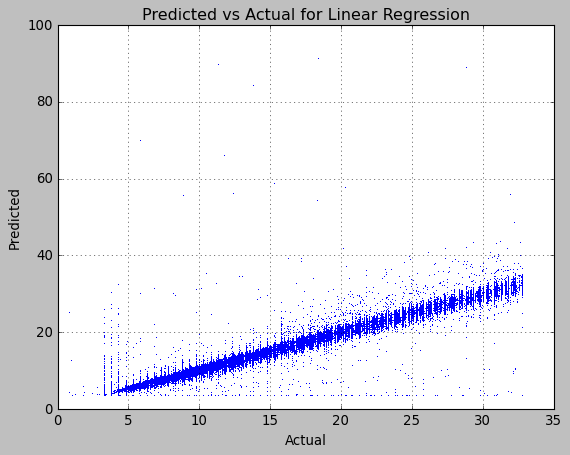

In [36]:
plt.plot(lr_predict_pd['total_amount'],lr_predict_pd['prediction'], 'b,')
plt.grid(True)
plt.title("Predicted vs Actual for Linear Regression")
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [37]:
#function to detemrine outliers in a dataframe given the df and the columns to elminate 
def outlier_outty(df, columns):
    for col in columns:
        col_mean = df.select(mean(df[col])).first()[0]
        col_std = df.select(stddev(df[col])).first()[0]
    
        # Filter out the outliers using the mean and standard deviation
        df = df.filter((df[col] > col_mean - 3 * col_std) & (df[col] < col_mean + 3 * col_std))

In [11]:
feature_for_map = new_df.select("passenger_count", "trip_distance", "tip_amount", "total_time")

#removing outliers from data. takes 34 seconds.
feature_for_map_outliers =  ["trip_distance", "tip_amount", "total_time"]

for col in feature_for_map_outliers:
        col_mean = feature_for_map.select(mean(feature_for_map[col])).first()[0]
        col_std = feature_for_map.select(stddev(feature_for_map[col])).first()[0]
    
        # Filter out the outliers using the mean and standard deviation
        feature_for_map = feature_for_map.filter((feature_for_map[col] > col_mean - 3 * col_std) & (feature_for_map[col] < col_mean + 3 * col_std))



feature_viz = feature_for_map.toPandas()

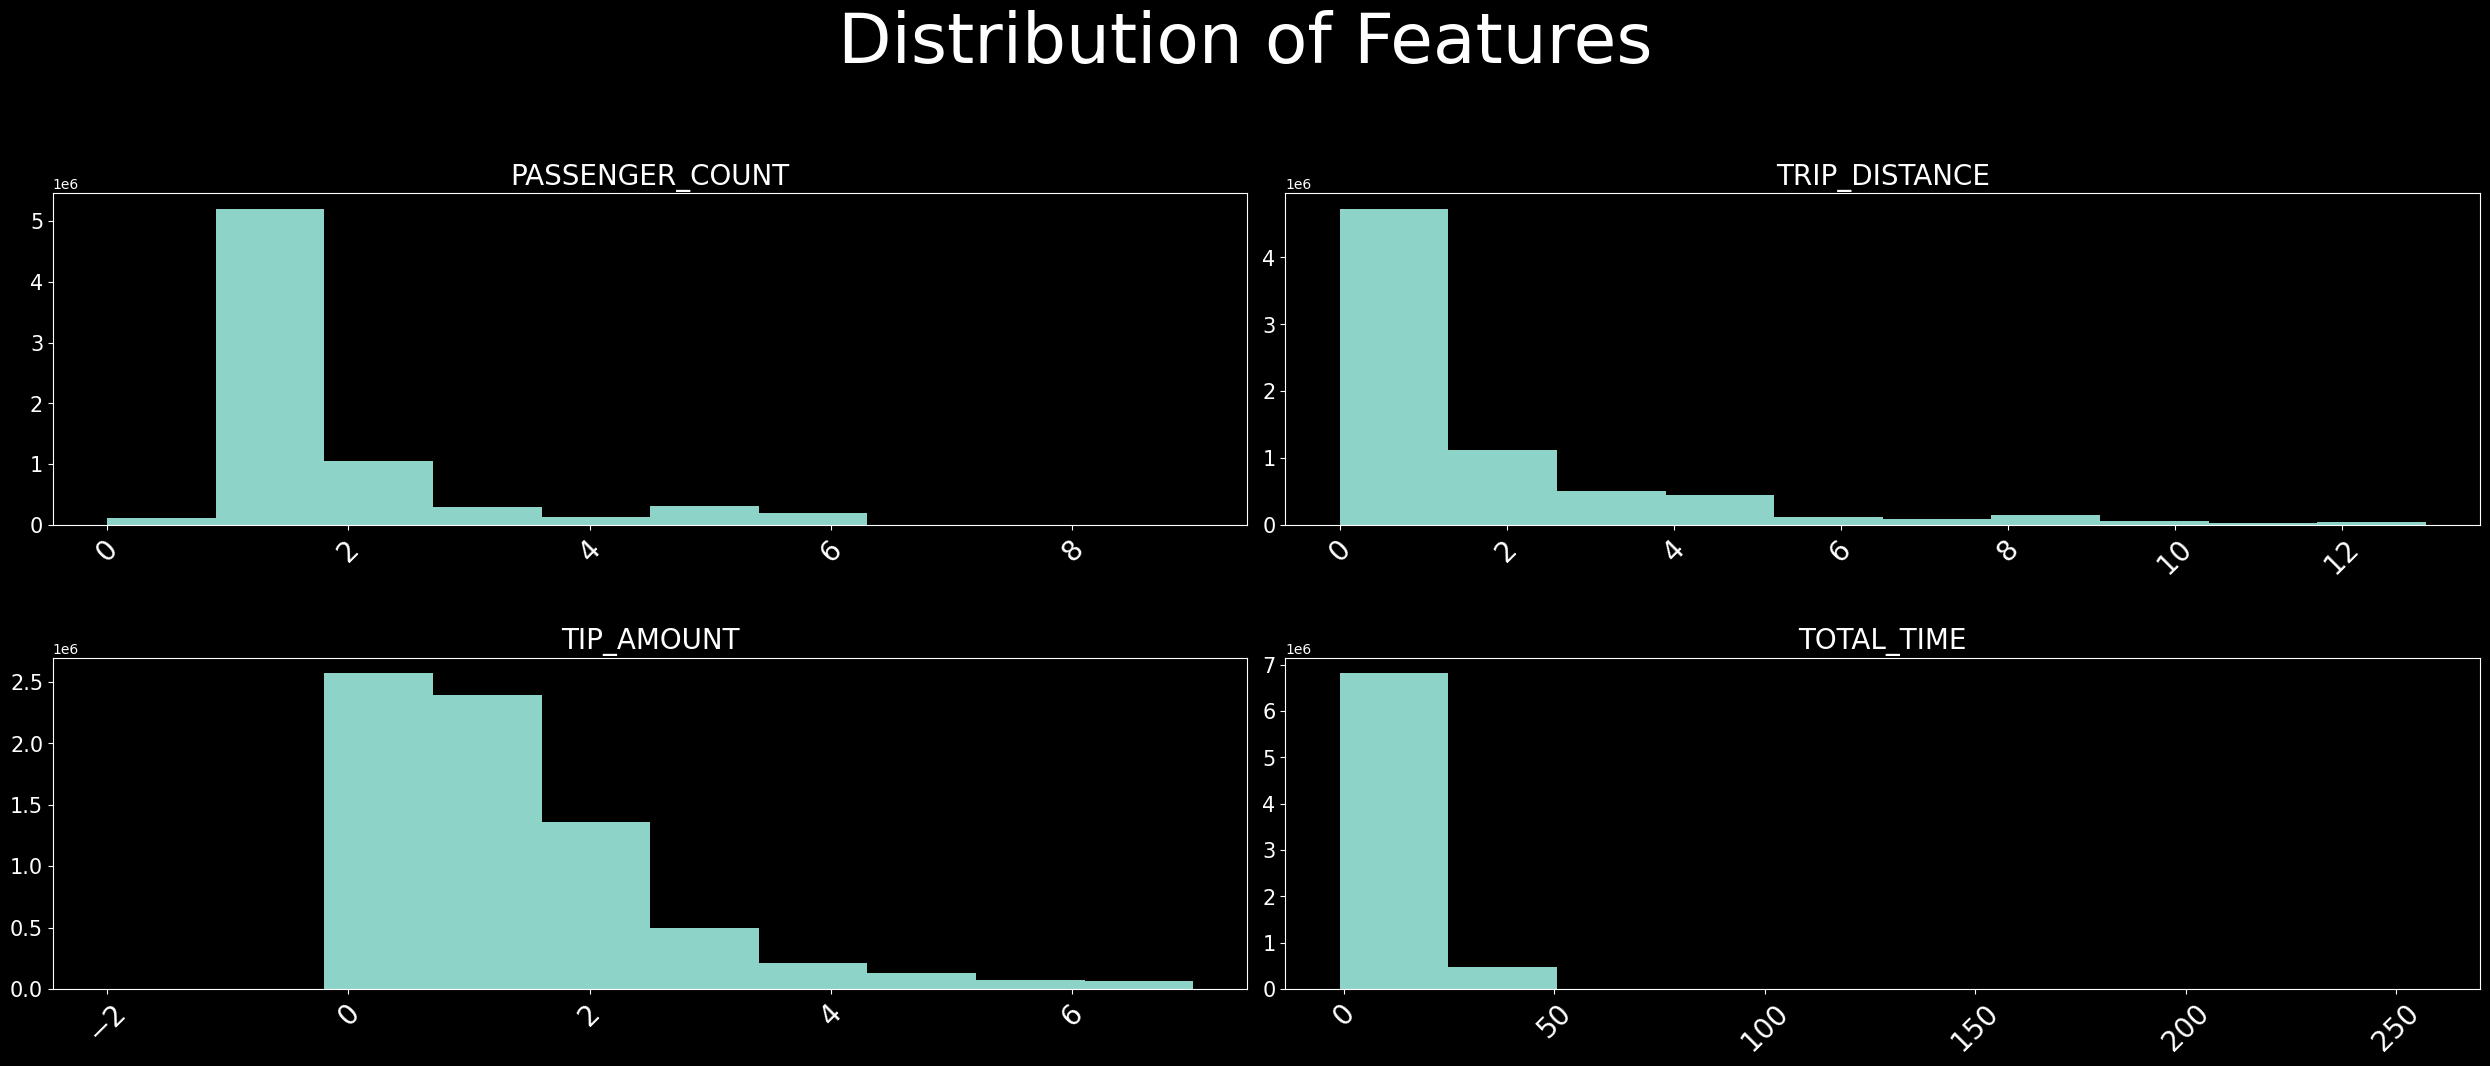

In [20]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(feature_viz.describe().columns, range(1,11)):
    ax = fig.add_subplot(3,2,num)
    ax.hist(feature_viz[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
    plt.style.use('dark_background') 
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [9]:
int_only_df.describe("trip_distance").show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|          7667792|
|   mean|2.801083849170687|
| stddev|3.737529402987084|
|    min|              0.0|
|    max|            831.8|
+-------+-----------------+



<AxesSubplot:title={'center':'Count of Miles riden in a taxi by each Customer'}, xlabel='Miles Riden in A taxi', ylabel='Occurances'>

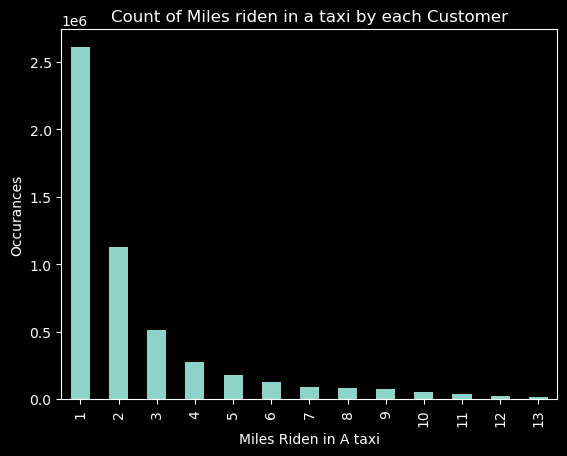

In [44]:
trip_dist= feature_viz[feature_viz["trip_distance"] > 0]
trip_dist["trip_distance"].value_counts().sort_index().plot(kind="bar", xlabel = "Miles Riden in A taxi", ylabel="Occurances", title= "Count of Miles riden in a taxi by each Customer")

<AxesSubplot:title={'center':'Do people tip when riding a taxi? Our data shows...'}, xlabel='Dollar value of tip given', ylabel='Count of tip'>

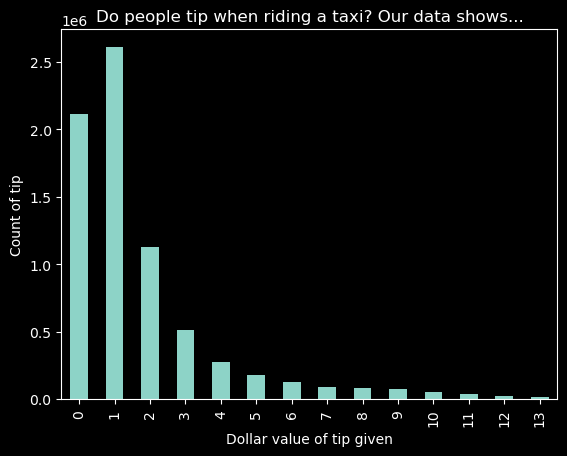

In [43]:
trip_dist= feature_viz[feature_viz["tip_amount"] > -1]
trip_dist["trip_distance"].value_counts().sort_index().plot(kind="bar", xlabel = "Dollar value of tip given", ylabel="Count of tip", title= "Do people tip when riding a taxi? Our data shows...")

In [55]:
feature_viz.head(10)

,passenger_count,trip_distance,tip_amount,total_time
0,1,1,1,6
1,1,2,1,19
2,3,0,0,4
3,5,0,0,3
4,5,0,0,1
5,5,0,0,2
6,5,0,0,4
7,1,1,1,7
8,1,3,3,13
9,2,2,1,12


In [50]:
mpl.style.use('classic')

C:\Users\tpald\AppData\Local\Temp\ipykernel_28832\1771923390.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b," (-> marker=','). The keyword argument will take precedence.
  plt.plot(feature_viz["tip_amount"],feature_viz["total_time"], 'b,', marker="^")


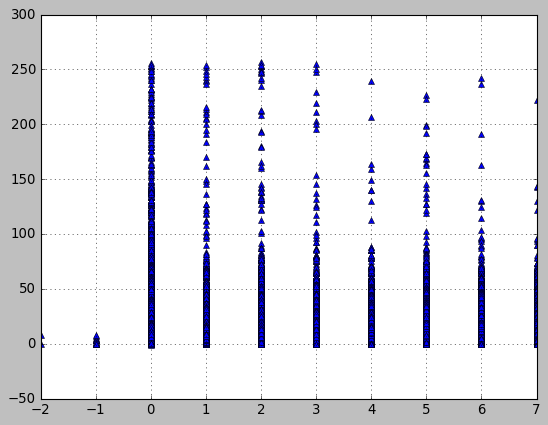

In [56]:
plt.plot(feature_viz["tip_amount"],feature_viz["total_time"], 'b,', marker="^")
plt.grid(True)